# Quality control (QC), denoising feature identification, and taxonomic classification with QIIME2
Contact person: Monica R. Ticlla <br>
Contact e-mail: mticlla@gmail.com monicaroxana.ticllaccenhua@unibas.ch

**Summary:** 

16S-rRNA-gene amplicon sequencing (hereafter 16S-AS) reads were processed with QIIME2 plugins. Briefly, after quality inspection of paired-end sequences with  QIIME2's demux plugin, we further processed the first sequence of each pair with DADA2; we run the denoise-single method of QIIME2's dada2 plugin, followed default parameter settings but adjusted the number of bases trimmed at the 5'- and 3'- ends. To create a phylogenetic tree of the resulting amplicon sequence variants (ASVs), we run the q2-fragment-insertion plugin which uses the SATé-enabled phylogenetic placement (SEPP) algorithm to insert our ASVs into the reference phylogeny of 16S rRNA gene sequences in Greengenes v13.8 (reference sequences clustered at 99\% sequence similarity); unplaced ASVs were removed. Finally,  we used the q2-feature-classifier plugin to assign taxonomic classifications to our ASVs; we first retrained the classifier with 16S V3-V4 fragments extracted from the Greengenes v13.8 reference sequences.

In [ ]:
report_date = %env REPORT_DATE
print(report_date)

## 0. Set-up working environment

**Set-up working directory**

In [1]:
%%capture
cd ../

**Import python modules**

In [2]:
#
from IPython.core.display import display, HTML
from zipfile import ZipFile
import pandas as pd
import matplotlib as mpl
import biom
from scipy.stats import spearmanr

**Create additional directories**

In [3]:
mkdir -p ./data/interim/QIIME2/tz_spt_cases_fwd

## 1. Import datasets

**Prepare fastq manifests for QIIME2**

In [4]:
%%bash
for i in `ls ./data/raw/tz_spt_cases/fastq_manifest_run*.tzv`;do 
    name=$(basename "$i"); 
    echo -e "sample-id\tabsolute-filepath" > ./data/raw/tz_spt_cases/${name%.*}_R1.tsv; 
    tail -n+2 $i|cut -f1,2 >> ./data/raw/tz_spt_cases/${name%.*}_R1.tsv
done

In [5]:
!ls ./data/raw/tz_spt_cases/fastq_manifest_run*_R1.tsv

./data/raw/tz_spt_cases/fastq_manifest_run1_R1.tsv
./data/raw/tz_spt_cases/fastq_manifest_run2_R1.tsv
./data/raw/tz_spt_cases/fastq_manifest_run3_R1.tsv


**Import FastQ data for QIIME2**

In [9]:
%%bash

mkdir -p ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts

# Remove line 9 if fastq files were downloaded from SRA
ls ./data/raw/tz_spt_cases/fastq_manifest_run*_R1.tsv | parallel \
    'tag="$(basename {} |cut -d. -f1 | cut -d_ -f3)"; \
    singularity exec \
        --bind ${GROUP} \
        --app QIIME2 ./containers/meta16S.sif \
        qiime tools import \
            --type "SampleData[SequencesWithQuality]" \
            --input-path {} \
            --input-format SingleEndFastqManifestPhred33V2 \
            --output-path ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/demux-single-end_${tag}.qza'

Imported ./data/raw/tz_spt_cases/fastq_manifest_run1_R1.tsv as SingleEndFastqManifestPhred33V2 to ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/demux-single-end_run1.qza
Imported ./data/raw/tz_spt_cases/fastq_manifest_run2_R1.tsv as SingleEndFastqManifestPhred33V2 to ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/demux-single-end_run2.qza
Imported ./data/raw/tz_spt_cases/fastq_manifest_run3_R1.tsv as SingleEndFastqManifestPhred33V2 to ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/demux-single-end_run3.qza


## 2. Sequence quality inspection

In [8]:
%%bash

# Remove line 8 if fastq files were downloaded from SRA
mkdir -p ./data/interim/QIIME2/tz_spt_cases_fwd/visualizations/rawQC
ls ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/demux-single-end_run*.qza | parallel \
    'tag="$(basename {} | cut -d. -f1 | cut -d_ -f2)"; \
    singularity exec \
        --bind ${GROUP} \
        --app QIIME2 ./containers/meta16S.sif \
        qiime demux summarize \
            --i-data {} \
            --o-visualization ./data/interim/QIIME2/tz_spt_cases_fwd/visualizations/rawQC/sequence-quality_${tag}.qzv \
            --p-n 1000'

Saved Visualization to: ./data/interim/QIIME2/tz_spt_cases_fwd/visualizations/rawQC/sequence-quality_run1.qzv
Saved Visualization to: ./data/interim/QIIME2/tz_spt_cases_fwd/visualizations/rawQC/sequence-quality_run2.qzv
Saved Visualization to: ./data/interim/QIIME2/tz_spt_cases_fwd/visualizations/rawQC/sequence-quality_run3.qzv


Visualization of the quality reports is limited from within this notebook, thus we visualized these files in [QIIME2view](https://view.qiime2.org/), and selected the following parameters for denoising with DADA2:

For `sequence-quality_run1.qzv`:
 - --p-trim-left 9
 - --p-trunc-len 293
 
For `sequence-quality_run2.qzv`:
 - --p-trim-left 15
 - --p-trunc-len 298
 
 For `sequence-quality_run3.qzv`:
 - --p-trim-left 15
 - --p-trunc-len 298

## 3. Denoising with DADA2

In [9]:
%%bash
mkdir -p ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/denoised/
let "CPU_AVAIL = $(nproc) - 1"
echo "Nr of CPUs: ${CPU_AVAIL}"
# Remove line 11 and 22 if fastq files were downloaded from SRA
time \
for imported_fastqs in $(ls ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/demux-single-end_run*.qza); do
    tag="$(basename ${imported_fastqs} | cut -d. -f1 | cut -d_ -f2)";
    if [ "$tag" = "run1" ];then
        echo $tag; \
        singularity exec \
        --bind ${GROUP} \
        --app QIIME2 ./containers/meta16S.sif qiime dada2 denoise-single \
            --i-demultiplexed-seqs ${imported_fastqs} \
            --p-trim-left 9 \
            --p-trunc-len 293 \
            --o-table ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/denoised/table_${tag} \
            --o-representative-sequences ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/denoised/rep-seqs_${tag}.qza \
            --o-denoising-stats ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/denoised/denoising-stats_${tag}.qza \
            --p-n-threads ${CPU_AVAIL}
    else
        singularity exec \
        --bind ${GROUP} \
        --app QIIME2 ./containers/meta16S.sif qiime dada2 denoise-single \
            --i-demultiplexed-seqs ${imported_fastqs} \
            --p-trim-left 15 \
            --p-trunc-len 298 \
            --o-table ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/denoised/table_${tag} \
            --o-representative-sequences ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/denoised/rep-seqs_${tag}.qza \
            --o-denoising-stats ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/denoised/denoising-stats_${tag}.qza \
            --p-n-threads ${CPU_AVAIL}
    fi
done

run1
Saved FeatureTable[Frequency] to: ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/denoised/table_run1.qza
Saved FeatureData[Sequence] to: ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/denoised/rep-seqs_run1.qza
Saved SampleData[DADA2Stats] to: ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/denoised/denoising-stats_run1.qza
Saved FeatureTable[Frequency] to: ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/denoised/table_run2.qza
Saved FeatureData[Sequence] to: ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/denoised/rep-seqs_run2.qza
Saved SampleData[DADA2Stats] to: ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/denoised/denoising-stats_run2.qza
Saved FeatureTable[Frequency] to: ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/denoised/table_run3.qza
Saved FeatureData[Sequence] to: ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/denoised/rep-seqs_run3.qza
Saved SampleData[DADA2Stats] to: ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/denoised/denoising-stats_run3.qza



real	83m48.619s
user	500m52.965s
sys	6m29.776s


In [ ]:
!cat /tmp/qiime2-q2cli-*.log

**Inspect the denoising stats**

In [10]:
%%bash
mkdir -p ./data/interim/QIIME2/tz_spt_cases_fwd/visualizations/denoised

# Remove line 8 if fastq files were downloaded from SRA
ls ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/denoised/denoising-stats_run*.qza | parallel \
    'tag="$(basename {} | cut -d. -f1 | cut -d_ -f2)"; \
    singularity exec \
        --bind ${GROUP} \
        --app QIIME2 ./containers/meta16S.sif \
        qiime metadata tabulate \
            --m-input-file {} \
            --o-visualization ./data/interim/QIIME2/tz_spt_cases_fwd/visualizations/denoised/denoising-stats_${tag}.qzv'

Saved Visualization to: ./data/interim/QIIME2/tz_spt_cases_fwd/visualizations/denoised/denoising-stats_run1.qzv
Saved Visualization to: ./data/interim/QIIME2/tz_spt_cases_fwd/visualizations/denoised/denoising-stats_run2.qzv
Saved Visualization to: ./data/interim/QIIME2/tz_spt_cases_fwd/visualizations/denoised/denoising-stats_run3.qzv


In [24]:
%%bash
unzip -l ./data/interim/QIIME2/tz_spt_cases/visualizations/denoised/denoising-stats_run3.qzv | head

Archive:  ./data/interim/QIIME2/tz_spt_cases/visualizations/denoised/denoising-stats_run3.qzv
  Length      Date    Time    Name
---------  ---------- -----   ----
       39  12-05-2019 18:20   1e285c13-d686-471c-b961-34c0c0e0012f/VERSION
       76  12-05-2019 18:20   1e285c13-d686-471c-b961-34c0c0e0012f/metadata.yaml
     2612  12-05-2019 18:20   1e285c13-d686-471c-b961-34c0c0e0012f/checksums.md5
    13269  12-05-2019 18:20   1e285c13-d686-471c-b961-34c0c0e0012f/data/index.html
     4428  12-05-2019 18:20   1e285c13-d686-471c-b961-34c0c0e0012f/data/metadata.tsv
     9973  12-05-2019 18:20   1e285c13-d686-471c-b961-34c0c0e0012f/data/css/datatables.min.css
  2396002  12-05-2019 18:20   1e285c13-d686-471c-b961-34c0c0e0012f/data/js/datatables.min.js


In [4]:
def load_denoising_stats(artifact_file):
    try:
        with ZipFile(artifact_file) as myzip:
            list_of_file_names = myzip.namelist()
            for file_name in list_of_file_names:
                if file_name.endswith('metadata.tsv'):
                    with myzip.open(file_name) as my_file:
                        denoising_stats= pd.read_csv(my_file, sep='\t', comment='#')
                    break
    except (OSError, EOFError, BufferError) as e:
        print(e)
    finally:
        return(denoising_stats)

# Load Denoising stats for run2
denoising_stats_run1_file = './data/interim/QIIME2/tz_spt_cases_fwd/visualizations/denoised/denoising-stats_run1.qzv'
denoising_stats_run1 = load_denoising_stats(denoising_stats_run1_file)
denoising_stats_run1['perc_kept'] = (denoising_stats_run1['non-chimeric']/denoising_stats_run1.input)*100

# Load Denoising stats for run2
denoising_stats_run2_file = './data/interim/QIIME2/tz_spt_cases_fwd/visualizations/denoised/denoising-stats_run2.qzv'
denoising_stats_run2 = load_denoising_stats(denoising_stats_run2_file)
denoising_stats_run2['perc_kept'] = (denoising_stats_run2['non-chimeric']/denoising_stats_run2.input)*100

# Load Denoising stats for run3
denoising_stats_run3_file = './data/interim/QIIME2/tz_spt_cases_fwd/visualizations/denoised/denoising-stats_run3.qzv'
denoising_stats_run3 = load_denoising_stats(denoising_stats_run3_file)
denoising_stats_run3['perc_kept'] = (denoising_stats_run3['non-chimeric']/denoising_stats_run3.input)*100

In [5]:
# Merge the three tables with denoising stats
denoising_stats_run123 = pd.concat([denoising_stats_run1,denoising_stats_run2,denoising_stats_run3], 
                                   ignore_index=True)
denoising_stats_run123.head()

# and save it
denoising_stats_merged_file = './data/interim/QIIME2/tz_spt_cases_fwd/visualizations/denoised/denoising-stats_run123.tsv'
denoising_stats_run123.to_csv(denoising_stats_merged_file, sep='\t', header=True, index=False)


In [17]:
%%bash
ls -lh ./data/interim/QIIME2/tz_spt_cases_fwd/visualizations/denoised/
head ./data/interim/QIIME2/tz_spt_cases_fwd/visualizations/denoised/denoising-stats_run123.tsv

total 47M
-rw-r--r-- 1 ticlla gagneux  17K 22. Jul 16:33 denoising-stats_run123.tsv
-rw-r--r-- 1 ticlla gagneux 1.2M 12. Jun 11:46 denoising-stats_run1.qzv
-rw-r--r-- 1 ticlla gagneux 1.2M 12. Jun 11:46 denoising-stats_run2.qzv
-rw-r--r-- 1 ticlla gagneux 1.2M 12. Jun 11:46 denoising-stats_run3.qzv
-rw-r--r-- 1 ticlla gagneux 4.2M 12. Jun 11:47 rep-seqs.qzv
drwxr-xr-x 2 ticlla gagneux  512 12. Jun 11:47 table_biom
-rw-r--r-- 1 ticlla gagneux 1.6M 12. Jun 11:47 table.qsv.qzv
-rw-r--r-- 1 ticlla gagneux  38M 12. Jun 11:47 table.tsv
sample-id	input	filtered	denoised	non-chimeric	perc_kept
A00030	69471	35777	33346	23903	34.40716270098314
A00034	46103	25102	24765	19104	41.4376504782769
A00036	59728	34850	34422	26914	45.06094294133405
A00038	53641	29543	28367	17434	32.50125836580228
A00053	440	121	49	49	11.136363636363637
A00056	35483	18274	17893	15719	44.3000873657808
A00059	52053	29268	28626	22594	43.40575951434115
A00066	1857	826	683	680	36.6182014001077
A00072	59076	33062	32380	26612	45.

Total number of reads processed:

In [8]:
denoising_stats_run123['input'].sum()

24630909

Lets get summarizing stats of the initial number of reads per sample:

In [10]:
denoising_stats_run123['input'].describe()

count       335.000000
mean      73525.101493
std       54685.915700
min         440.000000
25%       36666.500000
50%       55672.000000
75%       98143.500000
max      285493.000000
Name: input, dtype: float64

Total number of reads remaining after filtering, denoising and chimera removal:

In [11]:
denoising_stats_run123['non-chimeric'].sum()

12384275

Summarizing stats of remaining reads per sample:

In [13]:
denoising_stats_run123['non-chimeric'].describe()

count       335.000000
mean      36967.985075
std       26174.909128
min          49.000000
25%       19227.500000
50%       28231.000000
75%       45916.500000
max      144568.000000
Name: non-chimeric, dtype: float64

In [14]:
# Number of sequences(reads) remaining
print(denoising_stats_run1['non-chimeric'].describe())
print(denoising_stats_run2['non-chimeric'].describe())
print(denoising_stats_run3['non-chimeric'].describe())

count       33.000000
mean     27014.727273
std      11656.309526
min         49.000000
25%      19104.000000
50%      26612.000000
75%      36034.000000
max      45150.000000
Name: non-chimeric, dtype: float64
count      191.000000
mean     23278.832461
std      11079.530468
min       4301.000000
25%      15156.500000
50%      21688.000000
75%      28956.500000
max      60484.000000
Name: non-chimeric, dtype: float64
count       111.000000
mean      63482.270270
std       27644.742492
min       20784.000000
25%       36717.500000
50%       60649.000000
75%       83138.000000
max      144568.000000
Name: non-chimeric, dtype: float64


In [15]:
# Percentage of sequences remaining
print(denoising_stats_run1['perc_kept'].describe())
print(denoising_stats_run2['perc_kept'].describe())
print(denoising_stats_run3['perc_kept'].describe())

count    33.000000
mean     39.306822
std       6.680413
min      11.136364
25%      36.321234
50%      40.631613
75%      43.405760
max      53.279828
Name: perc_kept, dtype: float64
count    191.000000
mean      55.048007
std        3.896052
min       44.243969
25%       52.541441
50%       54.700308
75%       57.682957
max       65.530251
Name: perc_kept, dtype: float64
count    111.000000
mean      49.912136
std        3.775384
min       40.987164
25%       47.202873
50%       49.549071
75%       52.241140
max       59.808023
Name: perc_kept, dtype: float64


About 50% percent of the data is lost. Lets create a figure:

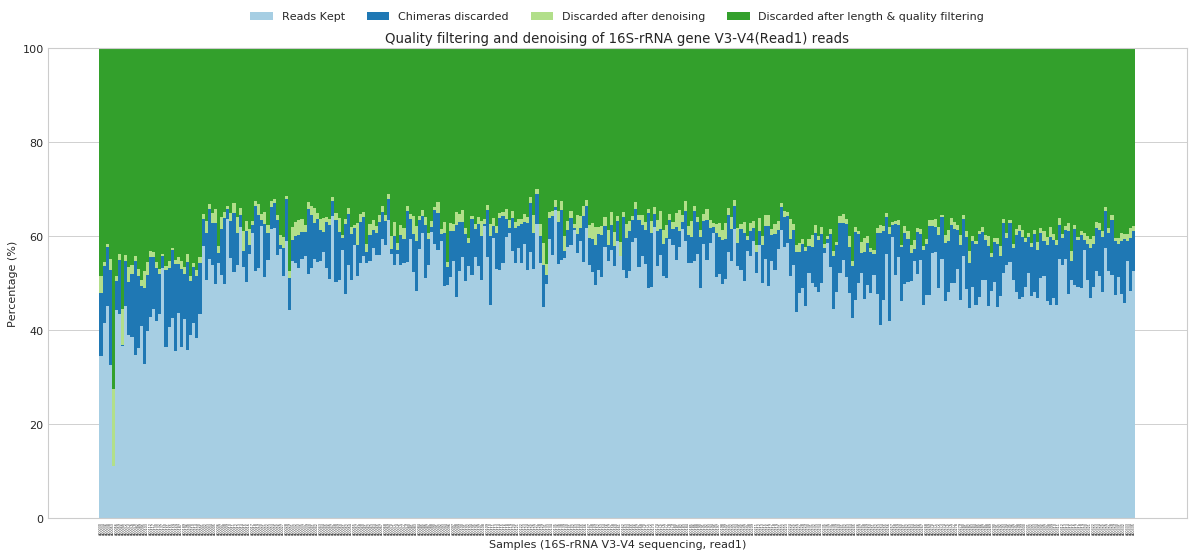

In [16]:
# Plots
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

filtering_discarded = [100*(input_r-filt_r)/input_r for input_r,filt_r in zip(denoising_stats_run123['input'],
                                                                 denoising_stats_run123['filtered'])]
denoising_discarded = [100*(filt_r-denoise_r)/input_r for input_r,filt_r,denoise_r in zip(denoising_stats_run123['input'],
                                                                                          denoising_stats_run123['filtered'], 
                                                                                          denoising_stats_run123['denoised'])]
chimeras_discarded = [100*(denoise_r-chim_r)/input_r for input_r,denoise_r,chim_r in zip(denoising_stats_run123['input'],
                                                                                         denoising_stats_run123['denoised'],
                                                                                         denoising_stats_run123['non-chimeric'])]
colors=['#a6cee3','#1f78b4','#b2df8a','#33a02c']
x_positions = range(0,len(filtering_discarded))
barwidth=1
with plt.style.context('seaborn-whitegrid'):
    my_dpi=80
    fig=plt.figure(figsize=(15, 7), dpi=my_dpi, facecolor='w', edgecolor='k')
    plt.bar(x_positions, denoising_stats_run123['perc_kept'], 
            color=colors[0], width=barwidth, label='Reads Kept')
    plt.bar(x_positions, chimeras_discarded, 
            bottom=denoising_stats_run123['perc_kept'], 
            color=colors[1], width=barwidth, label='Chimeras discarded')
    plt.bar(x_positions, denoising_discarded, 
            bottom=np.array(denoising_stats_run123['perc_kept'])+np.array(chimeras_discarded), 
            color=colors[2], width=barwidth, label='Discarded after denoising')
    plt.bar(x_positions, filtering_discarded, 
            bottom=np.array(denoising_stats_run123['perc_kept'])+np.array(chimeras_discarded)+np.array(denoising_discarded), 
            color=colors[3], width=barwidth, label='Discarded after length & quality filtering')
    plt.ylim(top=100)
    plt.xticks(x_positions,denoising_stats_run123['sample-id'],rotation=90,size=3)
    plt.xlabel('Samples (16S-rRNA V3-V4 sequencing, read1)')
    plt.ylabel('Percentage (%)')
    plt.title('Quality filtering and denoising of 16S-rRNA gene V3-V4(Read1) reads')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5,1.1), ncol=4)
    plt.tight_layout()
    plt.savefig('reports/figures/16S-AS_QC-filtering-denoising.svg', dpi=my_dpi)
plt.show()

**Merging denoised data**

https://docs.qiime2.org/2019.10/tutorials/fmt/

In [12]:
%%bash
singularity exec \
    --app QIIME2 ./containers/meta16S.sif \
    qiime feature-table merge \
        --i-tables ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/denoised/table_run1.qza \
        --i-tables ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/denoised/table_run2.qza \
        --i-tables ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/denoised/table_run3.qza \
        --o-merged-table ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/denoised/table.qza;
singularity exec \
    --app QIIME2 ./containers/meta16S.sif \
    qiime feature-table  merge-seqs \
        --i-data ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/denoised/rep-seqs_run1.qza \
        --i-data ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/denoised/rep-seqs_run2.qza \
        --i-data ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/denoised/rep-seqs_run3.qza \
        --o-merged-data ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/denoised/rep-seqs.qza;

Saved FeatureTable[Frequency] to: ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/denoised/table.qza
Saved FeatureData[Sequence] to: ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/denoised/rep-seqs.qza


**Convert denoised tables to biom format**

In [36]:
%%bash
singularity exec --app QIIME2 ./containers/meta16S.sif \
    qiime tools export \
        --input-path ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/denoised/table.qza \
        --output-path ./data/interim/QIIME2/tz_spt_cases_fwd/visualizations/denoised/table_biom
biom convert \
-i ./data/interim/QIIME2/tz_spt_cases_fwd/visualizations/denoised/table_biom/feature-table.biom \
-o ./data/interim/QIIME2/tz_spt_cases_fwd/visualizations/denoised/table.tsv \
--table-type="OTU table" --to-tsv

ls -lh ./data/interim/QIIME2/tz_spt_cases_fwd/visualizations/denoised

Exported ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/denoised/table.qza as BIOMV210DirFmt to directory ./data/interim/QIIME2/tz_spt_cases_fwd/visualizations/denoised/table_biom
total 46M
-rw-r--r-- 1 ticlla gagneux  17K 26. Feb 15:13 denoising-stats_run123.tsv
-rw-r--r-- 1 ticlla gagneux 1.2M  6. Dez 17:46 denoising-stats_run1.qzv
-rw-r--r-- 1 ticlla gagneux 1.2M  6. Dez 17:46 denoising-stats_run2.qzv
-rw-r--r-- 1 ticlla gagneux 1.2M  6. Dez 17:46 denoising-stats_run3.qzv
-rw-r--r-- 1 ticlla gagneux 4.2M  7. Dez 12:54 rep-seqs.qzv
drwxr-xr-x 2 ticlla gagneux  512 26. Feb 15:59 table_biom
-rw-r--r-- 1 ticlla gagneux 1.6M  7. Dez 12:53 table.qsv.qzv
-rw-r--r-- 1 ticlla gagneux  38M 26. Feb 15:59 table.tsv


**Summarizing visualizations of the denoised-merged tables (FeatureTable and FeatureData)**

In [14]:
%%bash
# Summary of the FeatureTable[Frequency]
singularity exec \
    --app QIIME2 ./containers/meta16S.sif \
    qiime feature-table summarize \
        --i-table ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/denoised/table.qza \
        --o-visualization ./data/interim/QIIME2/tz_spt_cases_fwd/visualizations/denoised/table.qsv

# Summary of the FeatureData[Sequence]
singularity exec \
    --app QIIME2 ./containers/meta16S.sif \
    qiime feature-table tabulate-seqs \
        --i-data ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/denoised/rep-seqs.qza \
        --o-visualization ./data/interim/QIIME2/tz_spt_cases_fwd/visualizations/denoised/rep-seqs.qzv

Saved Visualization to: ./data/interim/QIIME2/tz_spt_cases_fwd/visualizations/denoised/table.qsv.qzv
Saved Visualization to: ./data/interim/QIIME2/tz_spt_cases_fwd/visualizations/denoised/rep-seqs.qzv


Visualization of the summaries is limited from within this notebook, thus we visualized these files in [QIIME2view](https://view.qiime2.org/).

In [15]:
%%bash
unzip -l ./data/interim/QIIME2/tz_spt_cases_fwd/visualizations/denoised/table.qsv.qzv | head -n 10

Archive:  ./data/interim/QIIME2/tz_spt_cases_fwd/visualizations/denoised/table.qsv.qzv
  Length      Date    Time    Name
---------  ---------- -----   ----
       39  06-11-2020 23:23   b0480c21-620f-4196-8561-ece3b107b0c3/VERSION
       76  06-11-2020 23:23   b0480c21-620f-4196-8561-ece3b107b0c3/metadata.yaml
     5302  06-11-2020 23:23   b0480c21-620f-4196-8561-ece3b107b0c3/checksums.md5
       39  06-11-2020 23:23   b0480c21-620f-4196-8561-ece3b107b0c3/provenance/VERSION
       76  06-11-2020 23:23   b0480c21-620f-4196-8561-ece3b107b0c3/provenance/metadata.yaml
     3841  06-11-2020 23:23   b0480c21-620f-4196-8561-ece3b107b0c3/provenance/citations.bib
       39  06-11-2020 23:23   b0480c21-620f-4196-8561-ece3b107b0c3/provenance/artifacts/44e29951-4ed7-4033-aee2-2b6baf06f7e8/VERSION


In [19]:
def load_feature_table_sample_frequency(artifact_file):
    try:
        with ZipFile(artifact_file) as myzip:
            list_of_file_names = myzip.namelist()
            for file_name in list_of_file_names:
                if file_name.endswith('sample-frequency-detail.csv'):
                    with myzip.open(file_name) as my_file:
                        sample_frequency= pd.read_csv(my_file, sep=',', comment='#', 
                                                      header=None, names=['SampleID', 'FeatureCount'])
                    break
    except (OSError, EOFError, BufferError) as e:
        print(e)
    finally:
        return(sample_frequency)
feature_table_freq_file = './data/interim/QIIME2/tz_spt_cases_fwd/visualizations/denoised/table.qsv.qzv'
features_samples_frequency = load_feature_table_sample_frequency(feature_table_freq_file)
# Get a summary of feature counts (i.e number of reads) in samples
features_samples_frequency['FeatureCount'].describe()

count       335.000000
mean      36967.985075
std       26174.909128
min          49.000000
25%       19227.500000
50%       28231.000000
75%       45916.500000
max      144568.000000
Name: FeatureCount, dtype: float64

In [20]:
features_samples_frequency.head()

SampleID  FeatureCount
0   A00286      144568.0
1   A00276      122372.0
2   A00258      121818.0
3   A00290      118147.0
4   A00227      112741.0

## 4. Generate a phylogenetic tree from the features representative sequences

Perform fragment insertion of 16S sequences using the SEPP algorithm against the Greengenes 13_8 99% tree.

This notebook was run in an slurm interactive job. When running this step, it was throwing the following error:
```
mktemp: failed to create directory via template ‘/scratch/*/tmp.XXXXXXXXXX’: No such file or directory
/scif/apps/QIIME2/bin/run-sepp.sh: Can't create temp directory, exiting...
```
The solution was to bind `/scratch` to the singularity container.

In [5]:
%%bash
mkdir -p ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/tree/
let "CPU_AVAIL = $(nproc) - 1"
echo "Nr of CPUs: ${CPU_AVAIL}"
time \
singularity exec \
    --bind /scratch \
    --app QIIME2 ./containers/meta16S.sif \
        qiime fragment-insertion sepp \
        --i-representative-sequences ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/denoised/rep-seqs.qza \
        --o-tree ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/tree/tree.qza \
        --o-placements ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/tree/tree_placements.qza \
        --p-threads ${CPU_AVAIL} \
        --p-debug --verbose &>./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/tree/log.txt


real	135m28.656s
user	1485m8.169s
sys	31m35.418s


**Filter out unplaced representative sequences**

The tree built with `sepp` will exclude features that it couldn't insert within the reference tree. For further analysis, when using this tree we have to use a filtered FeatureTable where those unplaced features were removed:

In [9]:
%%bash
time \
singularity exec \
    --bind /scratch \
    --app QIIME2 ./containers/meta16S.sif \
        qiime fragment-insertion filter-features \
        --i-table ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/denoised/table.qza \
        --i-tree ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/tree/tree.qza \
        --o-filtered-table ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/tree/filtered_table.qza \
        --o-removed-table ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/tree/removed_table.qza \
        --verbose &>./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/tree/filter-features.log


real	6m26.961s
user	6m24.017s
sys	0m4.040s


Lets create a visualization of the filtered FeatureTable:

In [62]:
%%bash
mkdir -p ./data/interim/QIIME2/tz_spt_cases_fwd/visualizations/tree
# Summary of the FeatureTable[Frequency]
singularity exec \
    --app QIIME2 ./containers/meta16S.sif \
    qiime feature-table summarize \
        --i-table ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/tree/filtered_table.qza \
        --o-visualization ./data/interim/QIIME2/tz_spt_cases_fwd/visualizations/tree/filtered_table.qsv


Saved Visualization to: ./data/interim/QIIME2/tz_spt_cases_fwd/visualizations/tree/filtered_table.qsv.qzv


In [67]:
original_table_file = './data/interim/QIIME2/tz_spt_cases_fwd/visualizations/denoised/table.qsv.qzv'
filtered_table_file = './data/interim/QIIME2/tz_spt_cases_fwd/visualizations/tree/filtered_table.qsv.qzv'

original_table = load_feature_table_sample_frequency(original_table_file)
filtered_table = load_feature_table_sample_frequency(filtered_table_file)

Lets check how many features (i.e reads) were kept:

In [74]:
print((filtered_table.FeatureCount.sum()/original_table.FeatureCount.sum())*100)

99.99986272914644


Lets convert the filtered feature table to a biom table:

In [ ]:
%%bash
singularity exec --app QIIME2 ./containers/meta16S.sif \
    qiime tools export \
        --input-path ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/tree/filtered_table.qza \
        --output-path ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/tree/table_biom
biom convert \
-i ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/tree/table_biom/feature-table.biom \
-o ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/tree/filtered_table.tsv \
--table-type="OTU table" --to-tsv

ls -lh ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/tree/

## 5. Taxonomic classification

### 5.1 Train a feature classifier

**Obtain reference datasets**

We will download the most recent Greengenes 16S rRNA gene sequence database.

In [ ]:
%%bash
# NO NEED TO EXECUTE CODE BELOW, REFERENCE FILE ARE ALREADY AVAILABLE

# mkdir -p ./data/references/
# wget -O ./data/references/gg_13_8_otus.tar.gz \
#     "ftp://greengenes.microbio.me/greengenes_release/gg_13_5/gg_13_8_otus.tar.gz"
# tar -xzf ./data/references/gg_13_8_otus.tar.gz -C ./data/references/
# rm ./data/references/gg_13_8_otus.tar.gz

[ -d ./data/references/gg_13_8_otus ] && echo "Greengenes files found!" || echo 'Greengenes not found!'

**Import reference datasets as QIIME2 artifacts**

We will use the Greengenes reference seuqences clustered at 99% sequence similarity.

In [94]:
%%bash
mkdir -p ./data/interim/QIIME2/ref/artifacts/gg_13_8
singularity exec --app QIIME2 ./containers/meta16S.sif \
    qiime tools import \
        --type 'FeatureData[Sequence]' \
        --input-path ./data/references/gg_13_8_otus/rep_set/99_otus.fasta \
        --output-path ./data/interim/QIIME2/ref/artifacts/gg_13_8/99_otus.qza
        
singularity exec --app QIIME2 ./containers/meta16S.sif \
    qiime tools import \
        --type 'FeatureData[Taxonomy]' \
        --input-format HeaderlessTSVTaxonomyFormat \
        --input-path ./data/references/gg_13_8_otus/taxonomy/99_otu_taxonomy.txt \
        --output-path ./data/interim/QIIME2/ref/artifacts/gg_13_8/99_otu_taxonomy.qza

ls ./data/interim/QIIME2/ref/artifacts/gg_13_8

Imported ./data/references/gg_13_8_otus/rep_set/99_otus.fasta as DNASequencesDirectoryFormat to ./data/interim/QIIME2/ref/artifacts/gg_13_8/99_otus.qza
Imported ./data/references/gg_13_8_otus/taxonomy/99_otu_taxonomy.txt as HeaderlessTSVTaxonomyFormat to ./data/interim/QIIME2/ref/artifacts/gg_13_8/99_otu_taxonomy.qza
99_otus.qza
99_otu_taxonomy.qza
ref-taxonomy.qza


**Extract reference reads**

In our dataset, the sequences were amplified according to the "16S Metagenomic Sequencing Library Preparation" protocol from Illumina. This protocol targets the 16S V3 and V4 region of the 16S rRNA gene. The following primers:

- 16S Amplicon PCR Forward Primer = 5'-CCTACGGGNGGCWGCAG-3'
- 16S Amplicon PCR Reverse Primer = 5'-GACTACHVGGGTATCTAATCC-3'

The amplicon has approximately 460 bp.

In [95]:
%%bash
mkdir -p ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/taxonomy/

time \
singularity exec --app QIIME2 ./containers/meta16S.sif \
    qiime feature-classifier extract-reads \
        --i-sequences ./data/interim/QIIME2/ref/artifacts/gg_13_8/99_otus.qza \
        --o-reads ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/taxonomy/gg_13_8_99_training-seqs.qza \
        --p-f-primer CCTACGGGNGGCWGCAG \
        --p-r-primer GACTACHVGGGTATCTAATCC \
        --p-trunc-len 300 \
        --p-min-length 200 \
        --p-max-length 500 &>./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/taxonomy/extract_reads.log


real	11m25.882s
user	11m22.580s
sys	0m4.794s


**Train the Naive Bayes classifier**

In [96]:
%%bash

time \
singularity exec --app QIIME2 ./containers/meta16S.sif \
    qiime feature-classifier fit-classifier-naive-bayes \
    --i-reference-reads ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/taxonomy/gg_13_8_99_training-seqs.qza \
    --i-reference-taxonomy ./data/interim/QIIME2/ref/artifacts/gg_13_8/99_otu_taxonomy.qza \
    --o-classifier ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/taxonomy/classifier.qza


Saved TaxonomicClassifier to: ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/taxonomy/classifier.qza



real	5m47.029s
user	5m23.577s
sys	0m23.286s


### 5.2 Assign taxonomic classifications

In [98]:
%%bash
let "CPU_AVAIL = $(nproc) - 1"
echo "Nr of CPUs: ${CPU_AVAIL}"
time \
singularity exec --app QIIME2 ./containers/meta16S.sif \
    qiime feature-classifier classify-sklearn \
    --i-classifier ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/taxonomy/classifier.qza \
    --i-reads ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/denoised/rep-seqs.qza \
    --o-classification ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/taxonomy/taxonomy.qza \
    --p-n-jobs ${CPU_AVAIL} \
    --verbose &>./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/taxonomy/classify-sklearn.log



real	2m2.048s
user	23m59.922s
sys	0m26.327s


To give a look at the taxonomy assigned to the representative sequences of our dataset, we create a tabulated visualization:

In [99]:
%%bash
mkdir -p ./data/interim/QIIME2/tz_spt_cases_fwd/visualizations/taxonomy
time \
singularity exec --app QIIME2 ./containers/meta16S.sif \
    qiime metadata tabulate \
        --m-input-file ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/taxonomy/taxonomy.qza \
        --o-visualization ./data/interim/QIIME2/tz_spt_cases_fwd/visualizations/taxonomy/taxonomy.qzv


Saved Visualization to: ./data/interim/QIIME2/tz_spt_cases_fwd/visualizations/taxonomy/taxonomy.qzv



real	0m7.123s
user	0m4.562s
sys	0m4.055s


In [3]:
%%bash
# Export taxonomy table to 
time \
singularity exec --app QIIME2 ./containers/meta16S.sif \
    qiime tools export \
    --input-path './data/interim/QIIME2/tz_spt_cases_fwd/artifacts/taxonomy/taxonomy.qza' \
    --output-path './data/interim/QIIME2/tz_spt_cases_fwd/artifacts/taxonomy/exported'
    
ls ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/taxonomy/exported

Exported ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/taxonomy/taxonomy.qza as TSVTaxonomyDirectoryFormat to directory ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/taxonomy/exported
taxonomy.tsv



real	0m6.043s
user	0m3.869s
sys	0m2.548s
